In [1]:
# Imports
# !pip install torchinfo
import torch
import torch.nn as nn
import torch.utils.data as Data
from torchinfo import summary
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time
import Trainer_v03b1 as TP

## Network structures

In [8]:
m1 = TP.ImageEncoder()
summary(m1, input_size=(1, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
ImageEncoder                             [1, 256]                  --
├─Sequential: 1-1                        [1, 16, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 16, 64, 64]           160
│    └─Identity: 2-2                     [1, 16, 64, 64]           --
│    └─LeakyReLU: 2-3                    [1, 16, 64, 64]           --
├─Sequential: 1-2                        [1, 32, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 32, 32, 32]           4,640
│    └─Identity: 2-5                     [1, 32, 32, 32]           --
│    └─LeakyReLU: 2-6                    [1, 32, 32, 32]           --
├─Sequential: 1-3                        [1, 64, 16, 16]           --
│    └─Conv2d: 2-7                       [1, 64, 16, 16]           18,496
│    └─Identity: 2-8                     [1, 64, 16, 16]           --
│    └─LeakyReLU: 2-9                    [1, 64, 16, 16]           --
├─Seque

In [6]:
m2 = TP.ImageDecoder()
summary(m2, input_size=(1, 256))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Sequential: 1, Linear: 2, ReLU: 2, Linear: 2, ReLU: 2]

In [5]:
m3 =TP.CsiEncoder()
summary(m3, input_size=(2, 90, 100))

Layer (type:depth-idx)                   Output Shape              Param #
CsiEncoder                               [1, 256]                  353,374,464
├─Sequential: 1-1                        [1, 16, 30, 98]           --
│    └─Conv2d: 2-1                       [1, 16, 30, 98]           160
│    └─LeakyReLU: 2-2                    [1, 16, 30, 98]           --
├─Sequential: 1-2                        [1, 32, 14, 48]           --
│    └─Conv2d: 2-3                       [1, 32, 14, 48]           4,640
│    └─LeakyReLU: 2-4                    [1, 32, 14, 48]           --
├─Sequential: 1-3                        [1, 64, 12, 46]           --
│    └─Conv2d: 2-5                       [1, 64, 12, 46]           18,496
│    └─LeakyReLU: 2-6                    [1, 64, 12, 46]           --
├─Sequential: 1-4                        [1, 128, 10, 44]          --
│    └─Conv2d: 2-7                       [1, 128, 10, 44]          73,856
│    └─LeakyReLU: 2-8                    [1, 128, 10, 44]       

## Loader

In [2]:
transform = transforms.Compose([transforms.Resize([128,128]),
                                transforms.ToTensor(),
                           #     transforms.Normalize((0.5, ), (0.5, ))
])

data_train = datasets.MNIST(root = "../Dataset/MNIST/",
                            transform=transform,
                            train = True,
                            download = True)

data_test = datasets.MNIST(root="../Dataset/MNIST/",
                           transform = transform,
                           train = False)

train_loader = torch.utils.data.DataLoader(dataset=data_train,
                                           batch_size = 64,
                                           shuffle = True,
                                          drop_last=True)

valid_loader = train_loader

test_loader = torch.utils.data.DataLoader(dataset=data_test,
                                          batch_size = 64,
                                          drop_last=True,
                                          shuffle = True)

In [3]:
# Hyperparameters
t_args = TP.MyArgs(cuda=0, epochs=50, learning_rate=1e-4, criterion=nn.SmoothL1Loss(reduction='sum'))
s_args = TP.MyArgs(cuda=0, epochs=100, learning_rate=1e-5, criterion=nn.SmoothL1Loss())

In [4]:
# Model and Loss
imgencoder = TP.ImageEncoder(batchnorm=False, latent_dim=8).to(t_args.device)
imgdecoder = TP.ImageDecoder(latent_dim=8, active_func=nn.LeakyReLU(inplace=True)).to(t_args.device)
csiencoder = TP.CsiEncoder(batchnorm=False, latent_dim=8).to(t_args.device)
optimizer = torch.optim.Adam

trainer = TP.TrainerTS(imgencoder, imgdecoder, csiencoder,
                                   t_args, s_args, 
                                   train_loader, valid_loader, test_loader,
                                   optimizer, temperature=1)

In [5]:
# Load from checkpoints

imgencoder.load_state_dict(torch.load('../Models/AE-MNIST-ep530_En.pth'))
imgdecoder.load_state_dict(torch.load('../Models/AE-MNIST-ep530_De.pth'))

<All keys matched successfully>

In [8]:
# When changing learning rate
t_args = TP.MyArgs(cuda=0, epochs=100, learning_rate=1e-8, criterion=nn.SmoothL1Loss())
s_args = TP.MyArgs(cuda=0, epochs=100, learning_rate=1e-7, criterion=nn.SmoothL1Loss())
trainer.teacher_args = t_args
trainer.student_args = s_args

In [28]:
# Training and Saving
trainer.train_teacher()

Teacher: epoch=99/100,936/937of train, loss=0.012803282588720322
Total training time: 3321.5491106510162 sec


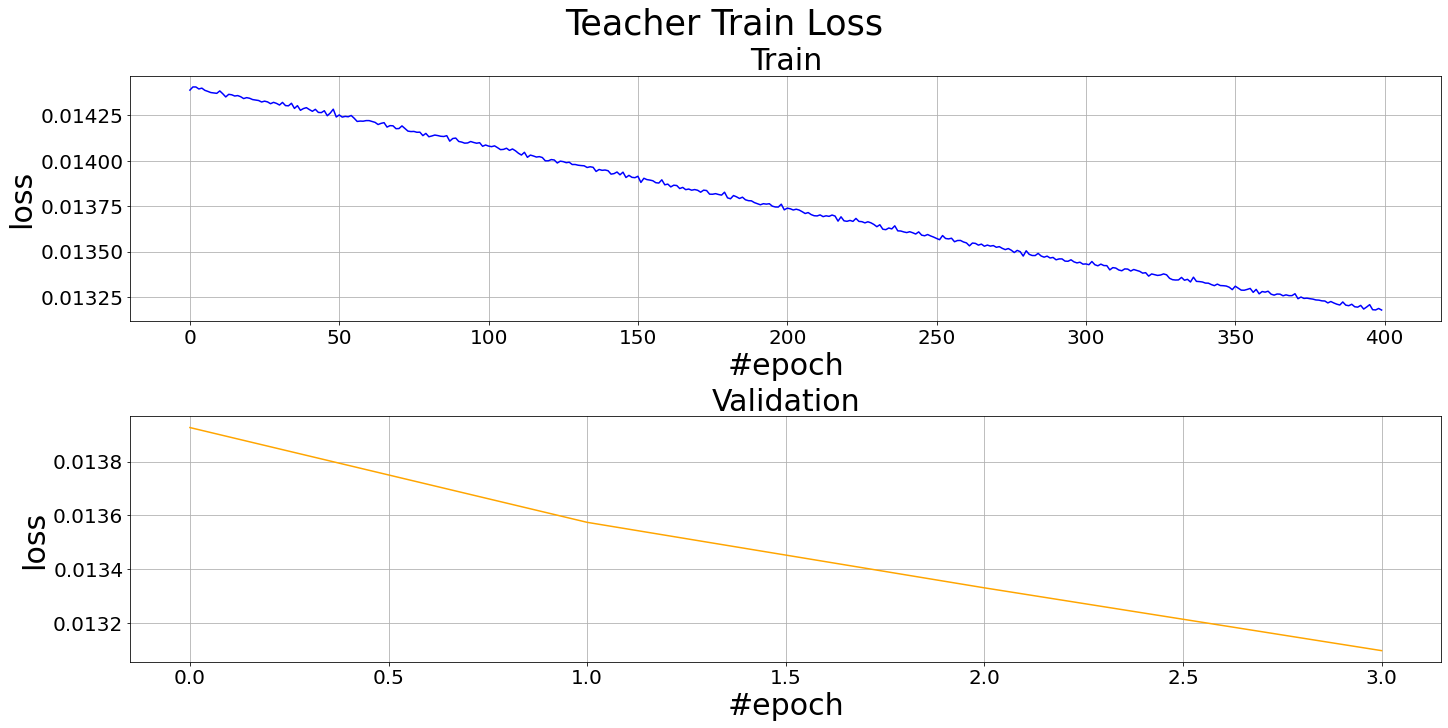

In [29]:
# Plot loss curves
%matplotlib inline
trainer.plot_teacher_loss()

In [30]:
  #=====================test============================
trainer.test_teacher(mode='train')

Teacher: 930/937of test, loss=0.0150424297899007834

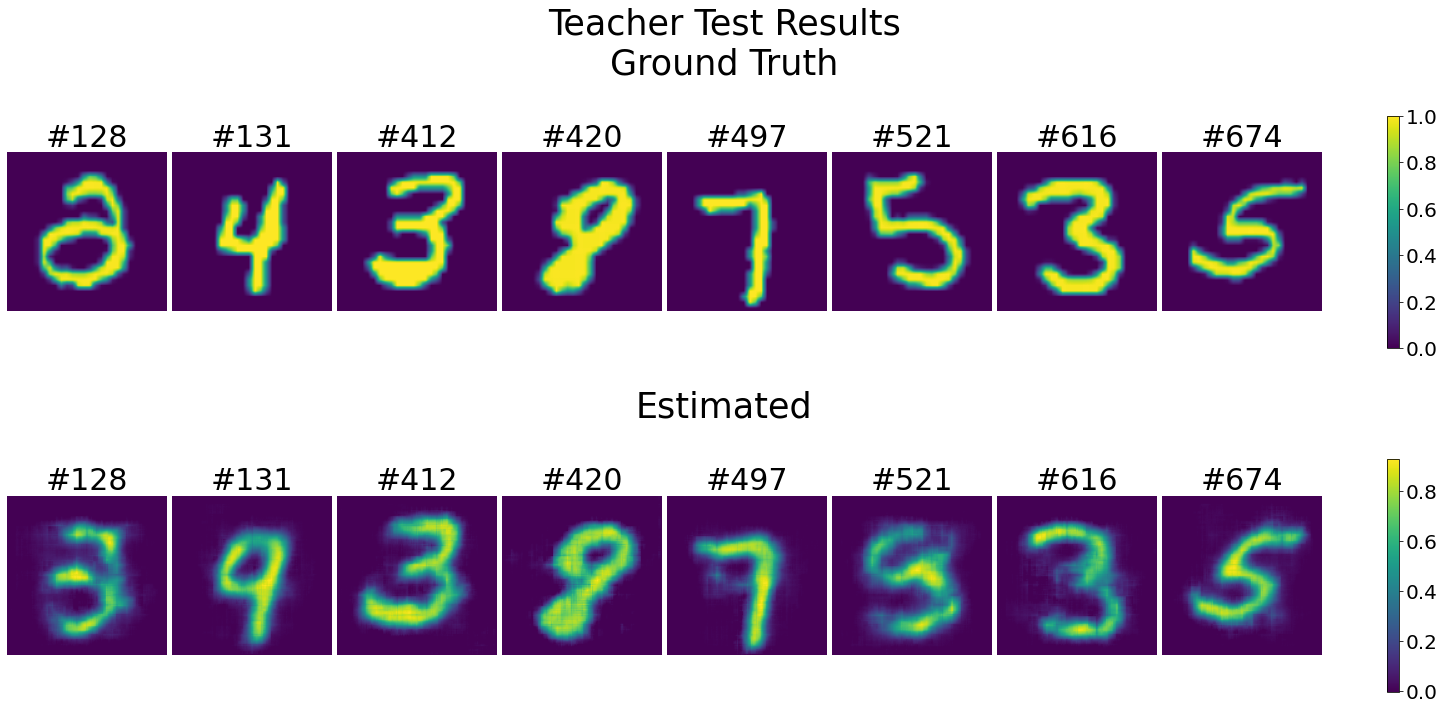

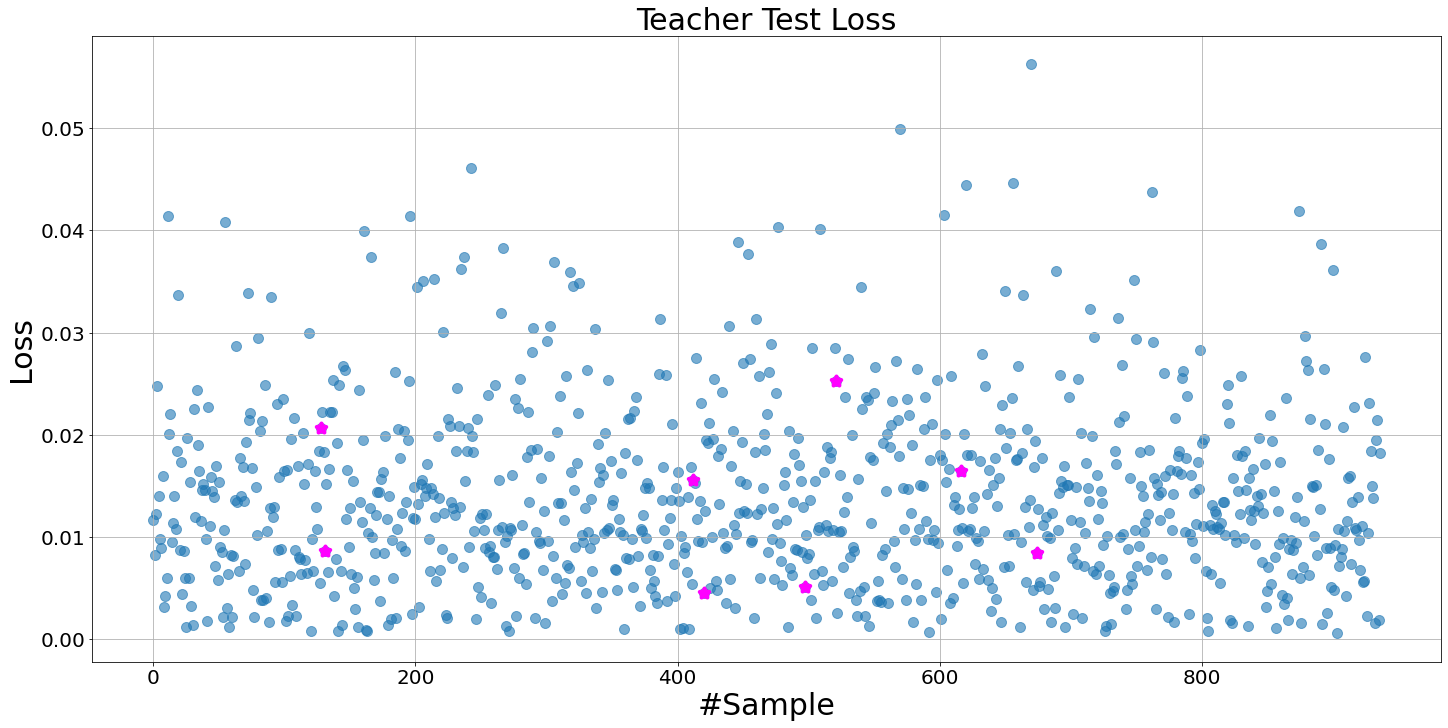

In [31]:
%matplotlib inline
trainer.plot_teacher_test()

In [57]:
torch.save(trainer.img_encoder.state_dict(),
                       '../Models/AE-MNIST-ep530_en.pth')
torch.save(trainer.img_decoder.state_dict(),
                       '../Models/AE-MNIST-ep530_de.pth')

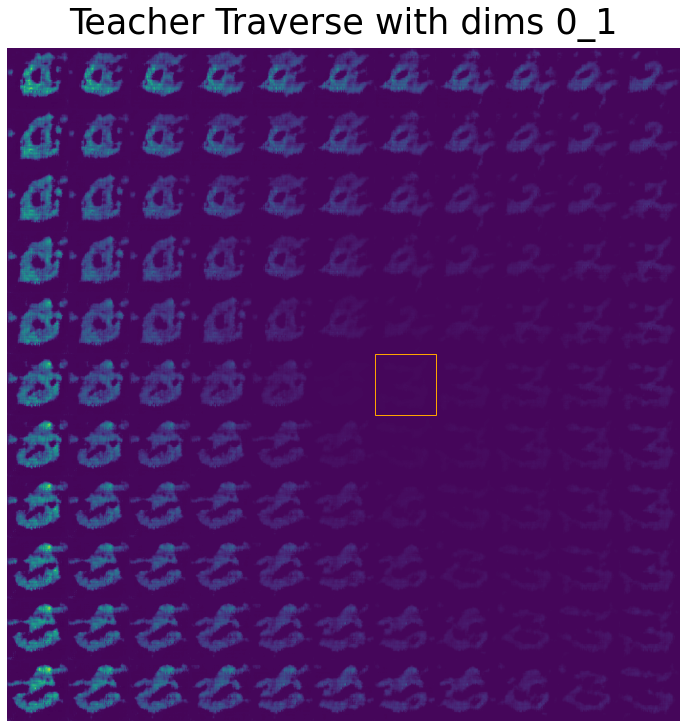

In [27]:
%matplotlib inline
trainer.traverse_latent(555, data_train, dim1=0, dim2=1)